# A feladat: Túlélés a Titanicon
A csatolt két adatbázis a Titanic utasainak adatait tartalmazza, illetve egy bináris változót, ami azt jelzi hogy az adott utas túlélte-e a balesetet. A rendelkezésre álló train adatbázison készíts egy statisztikai modell-t amely a balesetben történt elhalálozás valószínűségét becsüli meg. A feladatot bármilyen programnyelvben el lehet végezni, azonban a Python-ban vagy R-ben benyújtott válaszok extra pontot jelentenek.

# A szükséges könyvtárak importálása
Az adatok kezeléséhez pandas-t, az adatvizualizációhoz matplotlib-et és seaborn-t fogunk használni. A Titanic túlélőinek megjóslását pedig random forest módszerrel fogjuk végezni, melyhez a scikit learn könyvtárat használjuk majd.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# A tanító- és a teszthalmaz beolvasása

In [2]:
train_file_name = "DA_titanic_train.csv"
test_file_name = "DA_titanic_test.csv"

train = pd.read_csv(train_file_name, header=0, sep = ',')
test = pd.read_csv(test_file_name, header=0, sep = ',')

train_data = train.copy()
test_data = test.copy()

train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
4,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
619,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
620,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
621,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
622,889,0,3,"Johnston, Miss. Catherine Helen \Carrie\""""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [3]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,624.000000,624.000000,624.000000,494.000000,624.000000,624.000000,624.000000
mean,459.128205,0.383013,2.328526,29.658745,0.519231,0.354167,30.523470
std,257.314092,0.486511,0.822684,14.770773,1.071871,0.775559,48.186064
min,1.000000,0.000000,1.000000,0.670000,0.000000,0.000000,0.000000
25%,241.750000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800
50%,460.500000,0.000000,3.000000,28.000000,0.000000,0.000000,13.931250
75%,683.250000,1.000000,3.000000,38.000000,1.000000,0.000000,30.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,267.000000,267.000000,220.000000,267.000000,267.000000,267.000000
mean,415.318352,2.262172,29.789773,0.531835,0.445693,36.132224
std,255.301178,0.866346,13.995008,1.173773,0.871354,52.935439
min,4.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,174.500000,1.000000,21.000000,0.000000,0.000000,8.050000
50%,412.000000,3.000000,29.000000,0.000000,0.000000,16.100000
75%,629.500000,3.000000,39.000000,1.000000,1.000000,36.125000
max,890.000000,3.000000,70.000000,8.000000,5.000000,512.329200


# Adatvizualizáció és a hiányzó adatok kezelése
Megfigyelhetjük, hogy a tanítóhalmazban és a teszthalmazban is számos utasnak hiányzik az életkora és a kabinjának neve, továbbá egy-egy utasnak a felszállási helye?? (Embarked oszlop) is.

In [5]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            130
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          496
Embarked         1
dtype: int64

In [6]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             47
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          191
Embarked         1
dtype: int64

Az egy-egy hiányzó felszállási helyet a tanítóhalmazban előforduló leggyakoribb felszállási hellyel pótoljuk.

In [7]:
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
test_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

A túlélők osztályozása szempontjából kevésbé hasznosnak tűnő oszlopokat töröljük, köztük a sok hiányzó adatot tartalmazó kabinszámot is.

In [8]:
train_data.drop(columns= ['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_data.drop(columns= ['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,0,3,male,35.0,0,0,8.0500,S
4,1,2,female,14.0,1,0,30.0708,C
...,...,...,...,...,...,...,...,...
619,0,2,male,28.0,0,0,10.5000,S
620,0,3,male,25.0,0,0,7.0500,S
621,1,1,female,19.0,0,0,30.0000,S
622,0,3,female,NaN,1,2,23.4500,S


Az egyes oszlopok értékeinek eloszlása a tanítóhalmazban.

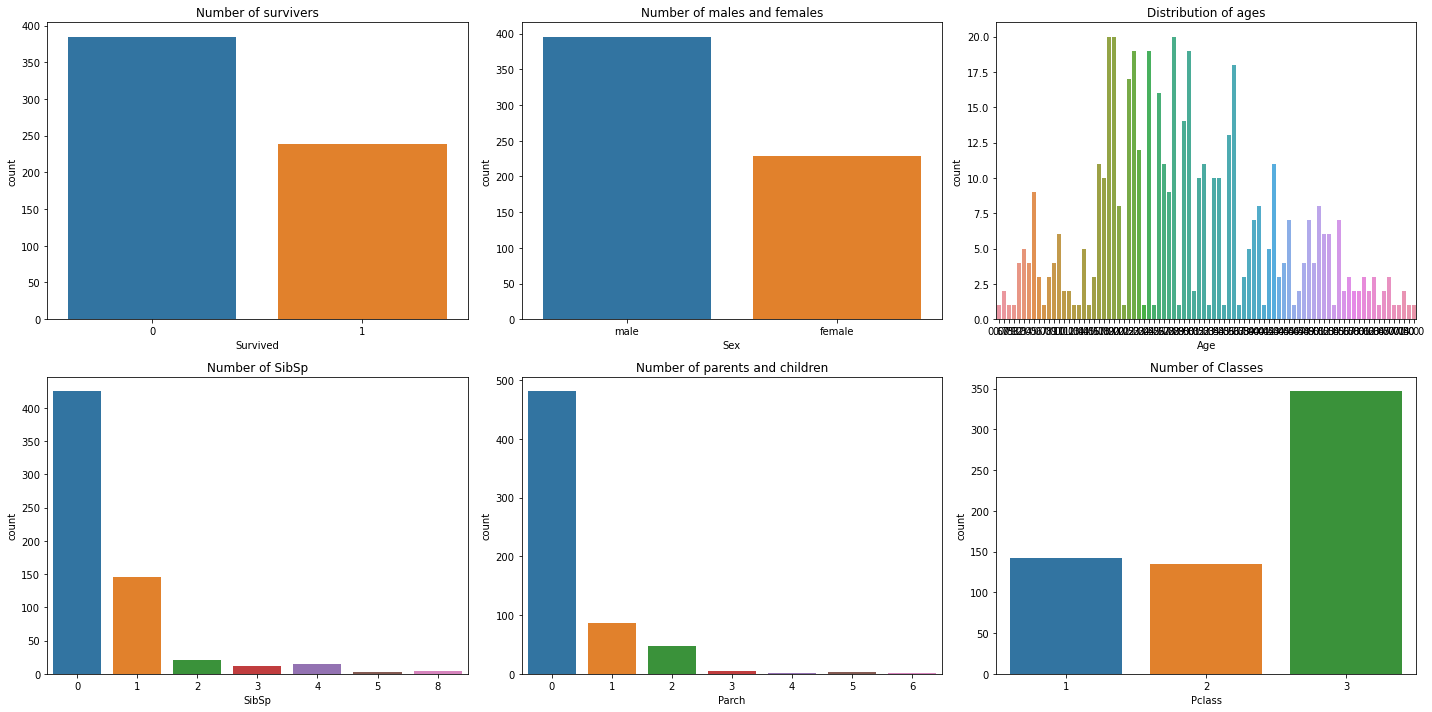

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
ax[0][0].set_title('Number of survivers')
sns.countplot(x='Survived', data=train_data, ax=ax[0][0])
ax[0][1].set_title('Number of males and females')
sns.countplot(x='Sex', data=train_data, ax=ax[0][1])
ax[0][2].set_title('Distribution of ages')
sns.countplot(x='Age', data=train_data, ax=ax[0][2])
ax[1][0].set_title('Number of SibSp')
sns.countplot(x='SibSp', data=train_data, ax=ax[1][0])
ax[1][1].set_title('Number of parents and children')
sns.countplot(x='Parch', data=train_data, ax=ax[1][1])
ax[1][2].set_title('Number of Classes')
sns.countplot(x='Pclass', data=train_data, ax=ax[1][2])
plt.tight_layout()

A túlélők és a halottak száma osztályonként, illetve nemenként. Megfigyelhetjük, hogy az első osztályon utazók és a nők között jelentősen magasabb volt a túlélési arány.

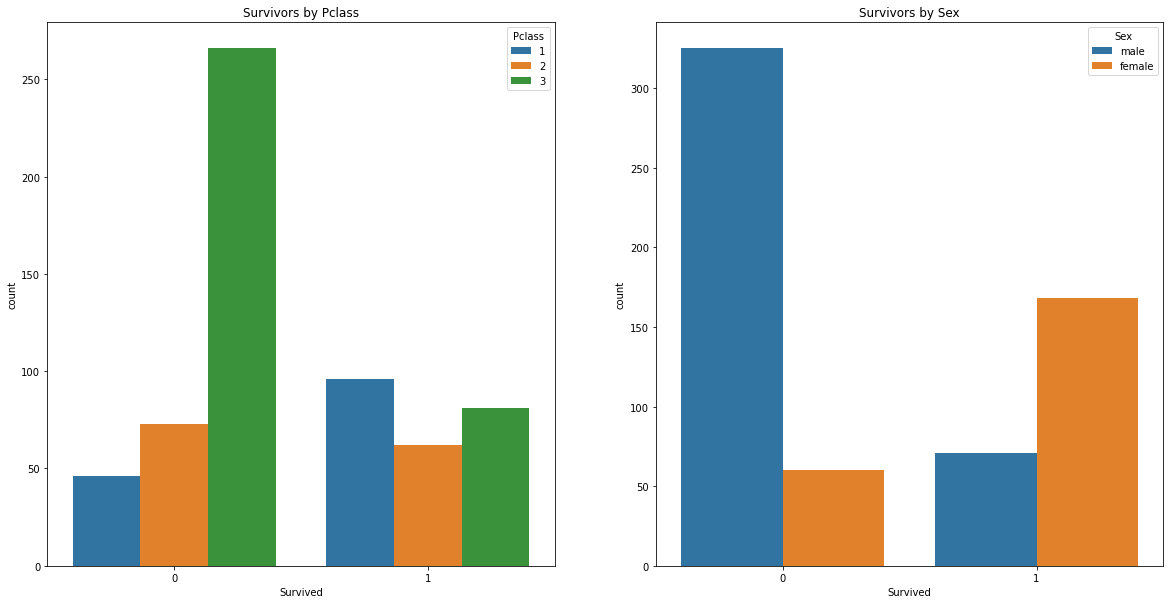

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].set_title('Survivors by Pclass')
sns.countplot(x='Survived', hue='Pclass', data=train_data, ax=ax[0])
ax[1].set_title('Survivors by Sex')
sns.countplot(x='Survived', hue='Sex', data=train_data, ax=ax[1])

A tanítóhalmazban az utasok száma osztályonként és nemenként, továbbá az egyes csoportok átlagéletkora.

In [11]:
print(train_data[['Sex', 'Pclass','Age']].groupby(['Pclass', 'Sex']).agg(['count','mean']))

                Age           
              count       mean
Pclass Sex                    
1      female    57  36.263158
       male      62  43.571290
2      female    54  28.731481
       male      71  30.577465
3      female    77  20.941558
       male     173  26.289017


A hiányzó életkorokat az adott személlyel azonos osztályon utazó, azonos nemű utasok életkorainak átlagával pótoljuk.

In [12]:
train_data['Age'] = train_data['Age'].fillna(train_data.groupby(['Pclass','Sex'])['Age'].transform('mean'))
test_data['Age'] = test_data['Age'].fillna(train_data.groupby(['Pclass','Sex'])['Age'].transform('mean'))

Ezáltal megszűntek a hiányzó adatok

In [13]:
train_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [14]:
test_data.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

A kategorikus oszlopokat (nem, felszállási hely) one-hot encoding-oljuk.

In [15]:
train_sex_dummies = pd.get_dummies(train_data.Sex, prefix='Sex')
train_embarked_dummies = pd.get_dummies(train_data.Embarked, prefix='Embarked')

test_sex_dummies = pd.get_dummies(test_data.Sex, prefix='Sex')
test_embarked_dummies = pd.get_dummies(test_data.Embarked, prefix='Embarked')

train_data = pd.concat([train_data, train_sex_dummies, train_embarked_dummies], axis=1)
test_data = pd.concat([test_data, test_sex_dummies, test_embarked_dummies], axis=1)

train_data = train_data.drop(['Sex', 'Embarked'], axis=1)
test_data = test_data.drop(['Sex', 'Embarked'], axis=1)

# A modell tanítása
A tanítóhalmazból leválasztjuk a kimenetet, azaz a Survived oszlopot.

In [16]:
y = train_data.Survived
X = train_data.drop(['Survived'], axis=1)

test_X = test_data
X

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,1,0,0,1
1,1,38.000000,1,0,71.2833,1,0,1,0,0
2,3,26.000000,0,0,7.9250,1,0,0,0,1
3,3,35.000000,0,0,8.0500,0,1,0,0,1
4,2,14.000000,1,0,30.0708,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
619,2,28.000000,0,0,10.5000,0,1,0,0,1
620,3,25.000000,0,0,7.0500,0,1,0,0,1
621,1,19.000000,0,0,30.0000,1,0,0,0,1
622,3,20.941558,1,2,23.4500,1,0,0,0,1


A tanítóhalmazt két részre osztjuk. Az adatok 70%-án fogjuk tanítani az osztályozó modellt, majd a maradék 30%-nyi adaton pedig kiértékeljük a modell teljesítményét.

In [17]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0, test_size=0.3, stratify=y)
print(train_X.shape, val_X.shape)
print(train_y.shape, val_y.shape)

(436, 10) (188, 10)
(436,) (188,)


Egy random forest osztályozót tanítunk összesen 100 döntési fával, melyek mélysége legfeljebb 6. Modellünk pontossága a validációs halmazon közel 80%-os.

In [18]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=6, min_samples_leaf=2, max_leaf_nodes=20).fit(train_X, train_y)
print("Accuracy: {}".format(rfc.score(val_X, val_y)))

y_pred = rfc.predict(val_X)
print(classification_report(val_y,y_pred))

Accuracy: 0.7925531914893617
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       116
           1       0.79      0.62      0.70        72

    accuracy                           0.79       188
   macro avg       0.79      0.76      0.77       188
weighted avg       0.79      0.79      0.79       188



Az egyik döntési fát ki is rajzoltatjuk.

[Text(1078.2608695652173, 2243.4285714285716, 'Sex_male <= 0.5\ngini = 0.48\nsamples = 275\nvalue = [262, 174]\nclass = 0'),
 Text(431.30434782608694, 1898.2857142857142, 'Pclass <= 2.5\ngini = 0.359\nsamples = 105\nvalue = [38, 124]\nclass = 1'),
 Text(323.4782608695652, 1553.142857142857, 'gini = 0.024\nsamples = 57\nvalue = [1, 82]\nclass = 1'),
 Text(539.1304347826086, 1553.142857142857, 'Age <= 32.5\ngini = 0.498\nsamples = 48\nvalue = [37, 42]\nclass = 1'),
 Text(431.30434782608694, 1208.0, 'Parch <= 0.5\ngini = 0.5\nsamples = 45\nvalue = [37, 36]\nclass = 0'),
 Text(215.65217391304347, 862.8571428571427, 'Fare <= 7.763\ngini = 0.449\nsamples = 28\nvalue = [16, 31]\nclass = 1'),
 Text(107.82608695652173, 517.7142857142856, 'gini = 0.172\nsamples = 13\nvalue = [2, 19]\nclass = 1'),
 Text(323.4782608695652, 517.7142857142856, 'SibSp <= 0.5\ngini = 0.497\nsamples = 15\nvalue = [14, 12]\nclass = 0'),
 Text(215.65217391304347, 172.57142857142844, 'gini = 0.43\nsamples = 9\nvalue = [11

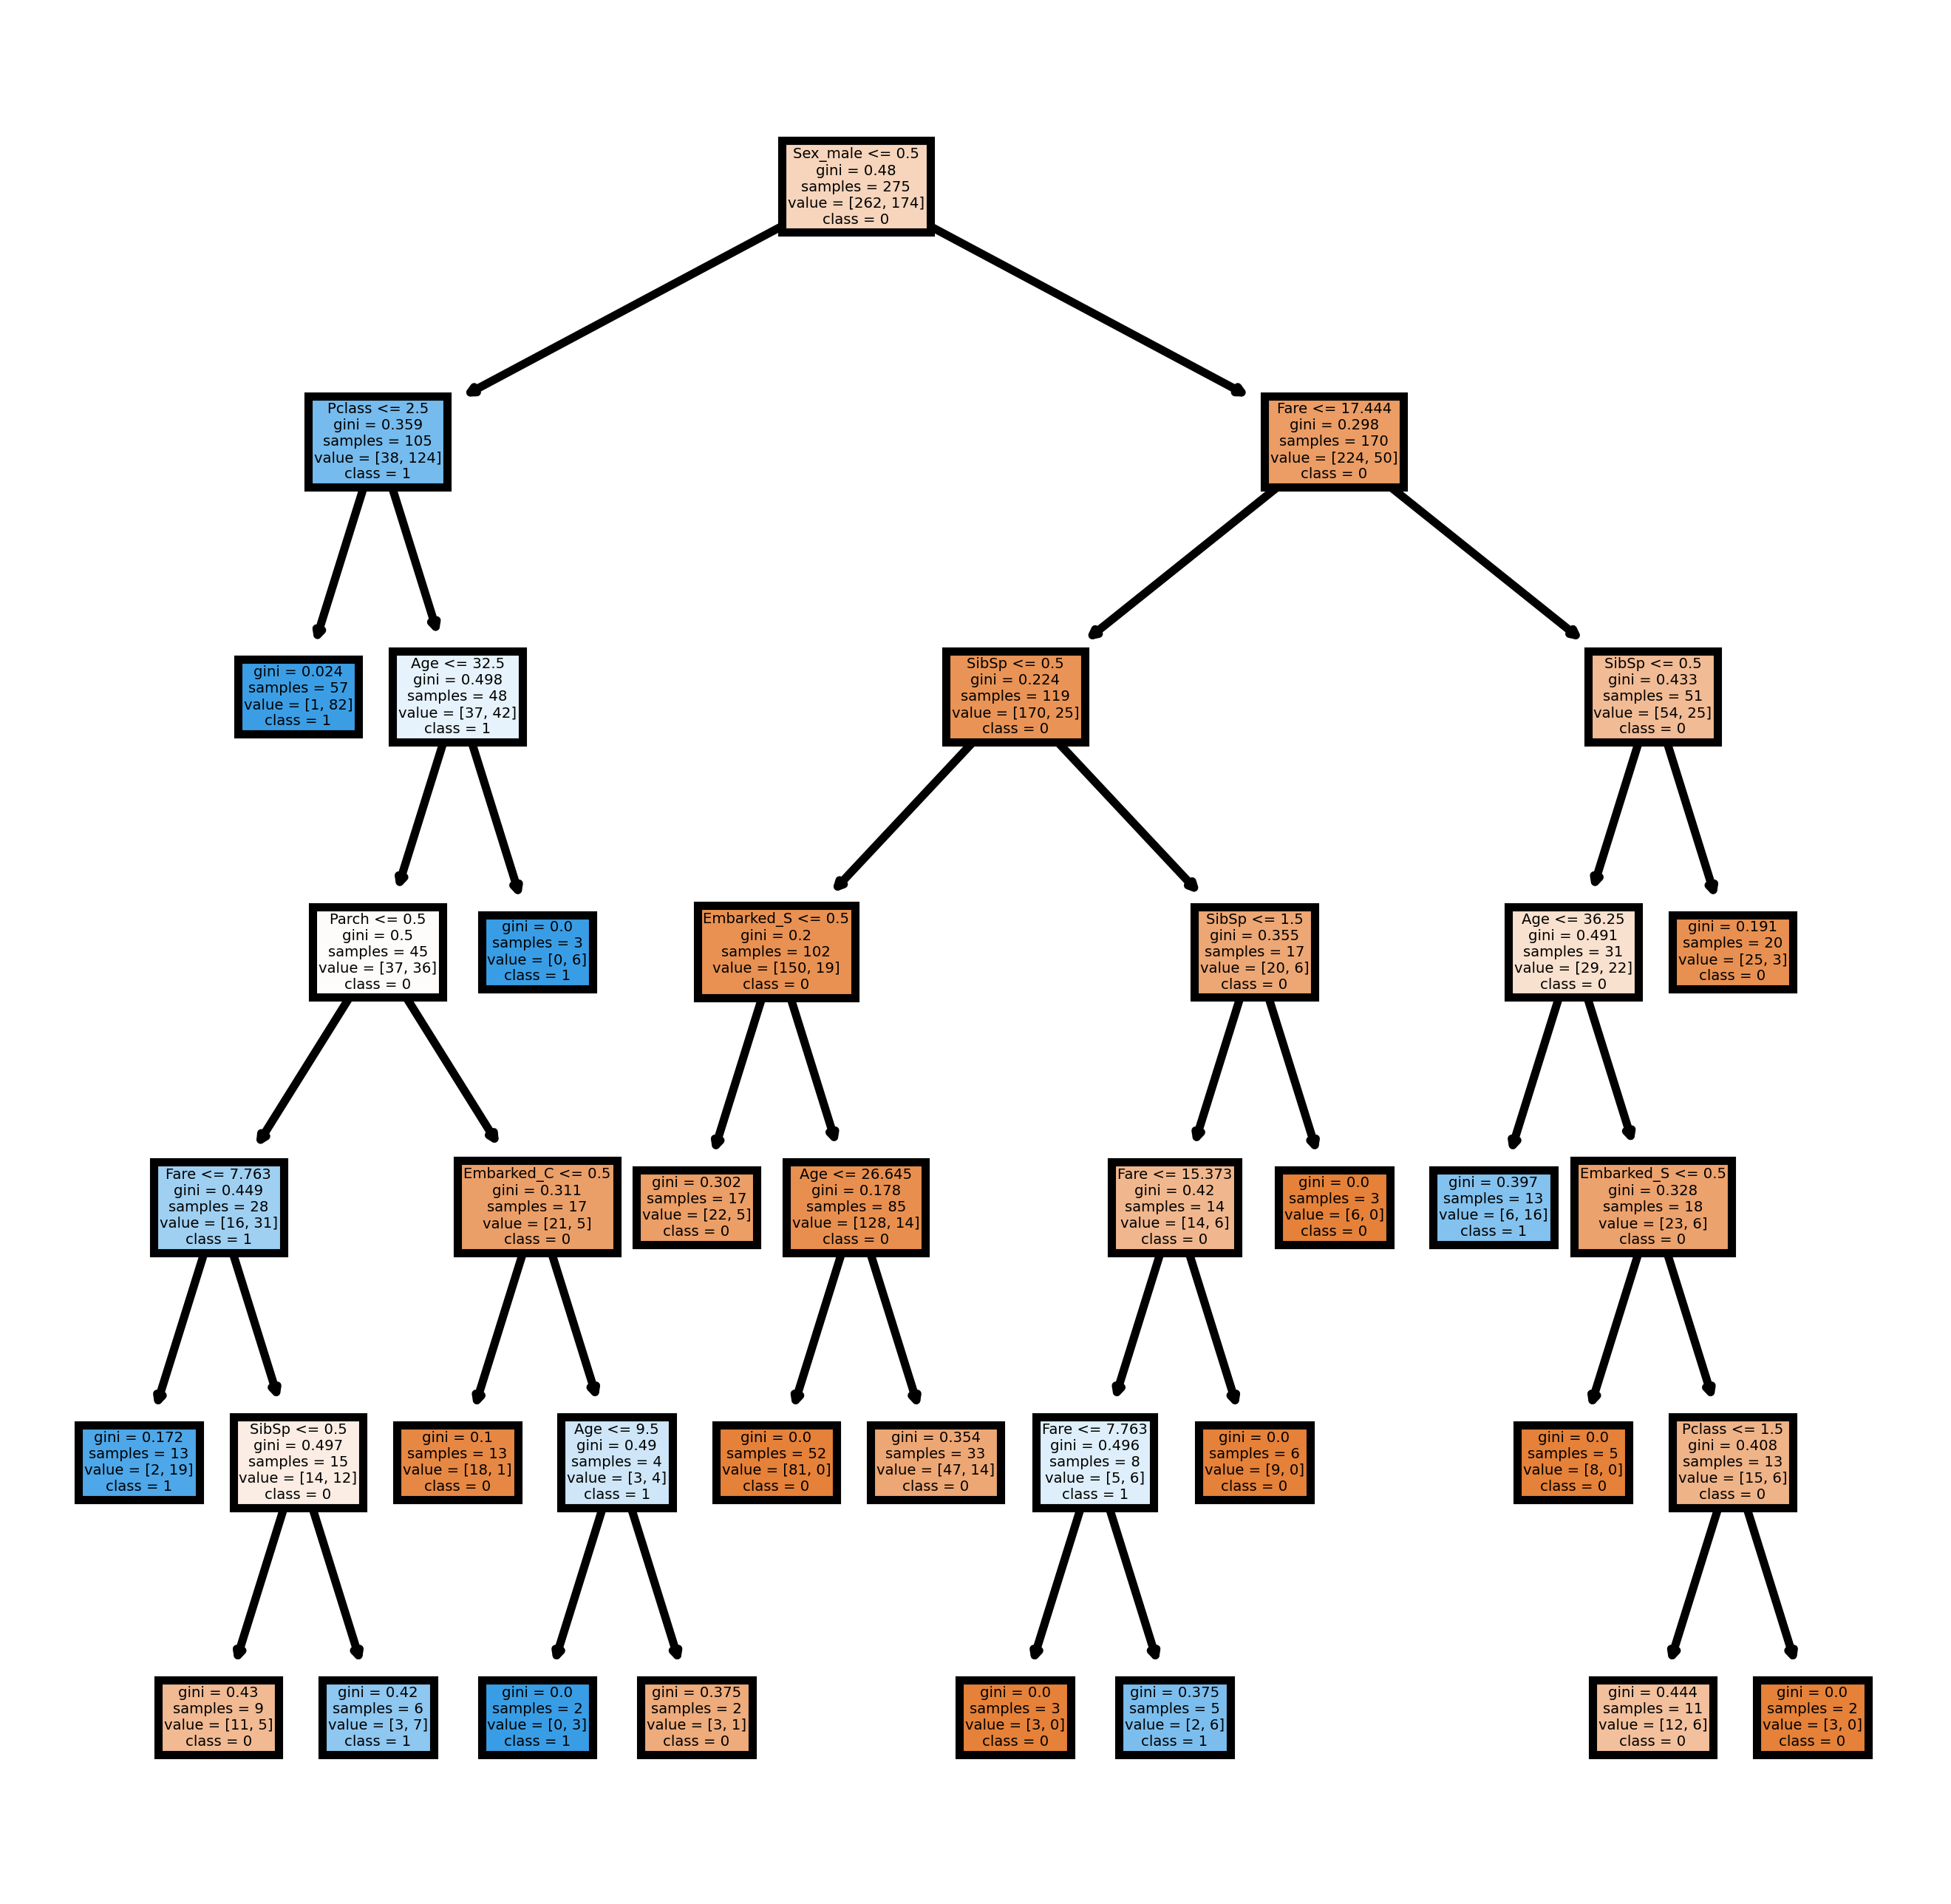

In [19]:
from sklearn import tree

fn = list(train_X.columns)
cn = rfc.classes_
fn=[str(x) for x in fn]
cn=[str(x) for x in cn]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rfc.estimators_[1],
               feature_names = fn, 
               class_names=cn,
               filled = True)

A végső modellt az összes tanítóadaton tanítjuk.

In [20]:
final_rfc = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=6, min_samples_leaf=2, max_leaf_nodes=20).fit(X, y)

# Predikció a teszthalmazon
A betanított modellel a teszthalmaz utasaira megjósoltatjuk a kimeneteket, illetve a túlélés és elhalálozás valószínűségét.

In [21]:
survived_predictions = final_rfc.predict(test_X)
predicted_probabilities = final_rfc.predict_proba(test_X)
prob = pd.DataFrame(predicted_probabilities)
prob.columns = ['DeathProb', 'SurvivedProb']
prob

,DeathProb,SurvivedProb
0,0.057755,0.942245
1,0.902395,0.097605
2,0.669999,0.330001
3,0.630370,0.369630
4,0.459538,0.540462
...,...,...
262,0.064109,0.935891
263,0.910961,0.089039
264,0.517897,0.482103
265,0.877152,0.122848


A jósolt eredményeket beillesztjük az eredeti teszthalmazba.

In [22]:
test_results = pd.concat([test, prob], axis=1)
test_results['SurvivedPrediction'] = survived_predictions.tolist()
test_results

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DeathProb,SurvivedProb,SurvivedPrediction
0,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.057755,0.942245,1
1,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0.902395,0.097605,0
2,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0.669999,0.330001,0
3,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0.630370,0.369630,0
4,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0.459538,0.540462,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,880,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C,0.064109,0.935891,1
263,882,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S,0.910961,0.089039,0
264,886,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,0.517897,0.482103,0
265,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0.877152,0.122848,0


Végül elmentjük az eredményt.

In [23]:
test_results.to_csv('test_results.csv', index=False, sep=',')